# Установка и импорт зависимостей

In [ ]:
pip install -r requirements.txt

In [3]:
import pyarrow.parquet as pq
import geopandas as gpd
import pandas as pd
import jupyter_black
import logging
import re
import os

In [4]:
jupyter_black.load()
logging.getLogger().setLevel(logging.INFO)

In [5]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

# Этап 1.
1. С сайта OSM GEOFABRICK downloads <link>https://download.geofabrik.de/russia.html</link> скачиваем .shp файлы территориальных округов РФ.
2. Распаковываем в папке src/OSM_Geofabric.
3. С помощью функции **merge_shapefiles** объединяем .shp файлы содержащие геометрию **POLYGON** в один единый файл, сохраняем его.

## Объединяем данные территории в один большой shapefile

In [6]:
def merge_shapefiles(input_folder, output_file):
    """
    Читает все Shape-файлы из указанной папки, фильтрует по типу геометрии и объединяет их в один файл.

    Параметры:
    - input_folder (str): Путь к папке, содержащей Shape-файлы.
    - output_file (str): Имя выходного файла для сохранения объединенного Shape-файла.
    """
    # Получаем список всех Shape-файлов в указанной папке
    shapefiles = [
        os.path.join(input_folder, file)
        for file in os.listdir(input_folder)
        if file.endswith(".shp")
    ]

    # Инициализируем список для хранения GeoDataFrames одного типа
    merged_gdf = None
    geometry_type = None

    for shapefile in shapefiles:
        gdf = gpd.read_file(shapefile)

        # Если это первый файл, сохраняем тип геометрии
        if merged_gdf is None:
            merged_gdf = gdf
            geometry_type = gdf.geometry.geom_type.iloc[0]
        else:
            # Проверяем тип геометрии и добавляем только подходящие GeoDataFrame
            if gdf.geometry.geom_type.iloc[0] == geometry_type:
                merged_gdf = gpd.GeoDataFrame(
                    pd.concat([merged_gdf, gdf], ignore_index=True)
                )
            else:
                logging.warning(
                    f"Пропущен файл {shapefile[18:]}: тип геометрии {gdf.geometry.geom_type.iloc[0]} не совпадает с {geometry_type}"
                )

    # Сохраняем объединенный Shape-файл, если есть данные
    if merged_gdf is not None:
        merged_gdf.to_file(output_file)
        logging.info(f"Объединенные Shape-файлы сохранены в {output_file}")
    else:
        logging.error("Нет данных для объединения.")


# Пример использования функции
input_folder = "src/OSM_Geofabric/Украина"  # Путь к папке с Shape-файлами
output_file = (
    "src/union_shapefiles/Украина"  # Путь и имя для сохранения объединенного файла
)

merge_shapefiles(input_folder, output_file)

C:\Users\Honor\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: 2GB file size limit reached for src/union_shapefiles/Украина\Украина.dbf. Going on, but might cause compatibility issues with third party software
  ogr_write(


# Этап 2
1. Считываем "большой" .shp файл
2. Отбираем строки со следующими населенными пунктами: city, town, village, hamlet, suburb
3. Сохраняем как GeoDataFrame

In [12]:
region = "Северо_Кавказский_федеральный_округ"

In [6]:
data = gpd.read_file(f"src/union_shapefiles/{region}/{region}.shp")

In [8]:
data.head(2)

,osm_id,code,fclass,name,type,population,geometry
0,40426402,1500,building,БТА,None,NaN,"POLYGON ((41.4404 43.64667, 41.44041 43.64675,..."
1,43317748,1500,building,None,None,NaN,"POLYGON ((40.79185 43.58217, 40.792 43.58228, ..."


In [9]:
geo_df = data[
    (
        data["fclass"].isin(
            [
                "city",  # город
                "town",  # небольшой город
                "village",  # деревни
                "hamlet",  # поселки
                "suburb",  # пригород снт
                "locality",  # поселения
            ]
        )
    )
    & (data["name"].notna())
]

In [10]:
geo_gdf = gpd.GeoDataFrame(geo_df, geometry="geometry")

In [ ]:
geo_df.to_file(f"src/geojson/{region}.geojson", driver="GeoJSON")

## Обработка .shp файлов Украины

In [128]:
data.head(20)

,osm_id,code,fclass,name,type,population,geometry
0,4338650,1500,building,None,construction,NaN,"POLYGON ((30.46599 50.374, 30.46734 50.3749, 30.46852 50.37417, 30.4678 50.37373, 30.46715 50.37331, 30.46599 50.374))"
1,4528325,1500,building,None,None,NaN,"POLYGON ((35.41496 45.32753, 35.41501 45.32758, 35.41508 45.32755, 35.41503 45.32749, 35.41496 45.32753))"
2,4528616,1500,building,None,None,NaN,"POLYGON ((35.41507 45.32777, 35.41517 45.32786, 35.41521 45.32784, 35.41511 45.32775, 35.41507 45.32777))"
3,4528933,1500,building,None,None,NaN,"POLYGON ((35.41229 45.33092, 35.41231 45.33094, 35.41237 45.3309, 35.41234 45.33088, 35.41229 45.33092))"
4,4529198,1500,building,None,None,NaN,"POLYGON ((33.71984 44.40865, 33.72014 44.40877, 33.7202 44.4087, 33.7199 44.40858, 33.71984 44.40865))"
5,4773441,1500,building,Міжнародний аеропорт «Львів» ім. Данила Галицького,None,NaN,"POLYGON ((23.95813 49.81394, 23.95819 49.81397, 23.95851 49.81377, 23.9587 49.81389, 23.95923 49.81423, 23.95925 49.81421, 23.95949 49.81405, 23.96042 49.81344, 23.96064 49.8133, 23.96073 49.81324, 23.96054 49.81312, 23.96229 49.81197, 23.96211 49.81185, 23.96175 49.81209, 23.9616 49.81199, 23.96121 49.81174, 23.96116 49.81177, 23.96156 49.81202, 23.96171 49.81212, 23.96092 49.81264, 23.96077 49.81254, 23.96038 49.81229, 23.96033 49.81232, 23.96073 49.81257, 23.96088 49.81267, 23.96062 49.81283, 23.96023 49.81258, 23.95996 49.81275, 23.95992 49.81273, 23.9598 49.81281, 23.95964 49.81271, 23.95959 49.81268, 23.95957 49.81269, 23.95962 49.81273, 23.95978 49.81283, 23.95939 49.81308, 23.95924 49.81298, 23.95919 49.81295, 23.95917 49.81296, 23.95922 49.81299, 23.95938 49.81309, 23.95895 49.81337, 23.9588 49.81327, 23.95875 49.81324, 23.95873 49.81325, 23.95878 49.81328, 23.95894 49.81338, 23.95852 49.81366, 23.95837 49.81356, 23.95832 49.81353, 23.9583 49.81354, 23.95835 49.81357, 23.9585 49.81367, 23.95843 49.81372, 23.95844 49.81373, 23.95813 49.81394))"
6,23118657,1500,building,None,apartments,NaN,"POLYGON ((30.62538 50.43625, 30.62555 50.43629, 30.62591 50.4357, 30.62574 50.43566, 30.62538 50.43625))"
7,23151565,1500,building,None,apartments,NaN,"POLYGON ((30.62585 50.43546, 30.62601 50.4355, 30.62636 50.43491, 30.6262 50.43487, 30.62585 50.43546))"
8,23151566,1500,building,ЖРЕО-417,apartments,NaN,"POLYGON ((30.62573 50.43636, 30.62629 50.4365, 30.62635 50.4364, 30.62579 50.43626, 30.62573 50.43636))"
9,23151569,1500,building,None,apartments,NaN,"POLYGON ((30.6265 50.43652, 30.62667 50.43656, 30.62714 50.43578, 30.62697 50.43574, 30.6265 50.43652))"


# Этап 3.
## Функция пространственного объединения геолокации и полигонов

In [119]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point


def spatial_join_with_location(df, polygons_gdf):
    """
    Пространственное объединение датафрейма с геолокацией человека и полигонов.

    Параметры:
    - df: DataFrame с колонками ['username', 'client', 'latitude', 'longitude']
    - polygons_gdf: GeoDataFrame с полигонами, к которым нужно привязать геолокации.

    Возвращает:
    - GeoDataFrame с результатом пространственного объединения.
    """
    # Преобразуем точки в геометрический формат Point
    df["geometry"] = df.apply(
        lambda row: Point(row["longitude"], row["latitude"]), axis=1
    )

    # Преобразуем DataFrame в GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry="geometry")

    # Установим систему координат (например, WGS84)
    gdf.set_crs(epsg=4326, inplace=True)

    # Выполняем пространственное объединение
    result_gdf = gpd.sjoin(gdf, polygons_gdf, how="left")

    return result_gdf


# Пример данных с геолокацией пользователя
data = {
    "epk_id": ["1"],
    "fio": ["Вася Олейник"],
    "latitude": [54.633186],
    "longitude": [20.908047],
}
df = pd.DataFrame(data)

# Пример GeoDataFrame с полигонами (например, города или области)
# Полигональные данные могут быть загружены из файлов типа Shapefile или GeoJSON
# polygons_gdf = gpd.read_file('path_to_polygon_shapefile.shp')

# Пример использования функции (нужно загрузить реальные полигональные данные)
result = spatial_join_with_location(df, geo_gdf)

# print(result)

In [120]:
result

,epk_id,fio,latitude,longitude,geometry,index_right,osm_id,fclass,name,population
0,1,Вася Олейник,54.633186,20.908047,POINT (20.90805 54.63319),331,974610084,village,Озерки,0.0
0,1,Вася Олейник,54.633186,20.908047,POINT (20.90805 54.63319),12887,974610084,village,Озерки,0.0


In [13]:
### СПИСОК ВСЕХ ГЕОДАТАФРЕЙМОВ
gdf_names_list = [
    "Дальневосточный_федеральный_округ",
    "Калининград",
    "Крымский_федеральный_округ",
    "Приволжский_федеральный_округ",
    "Северо_Западный_федеральный_округ",
    "Северо_Кавказский_федеральный_округ",
    "Сибирский_федеральный_округ",
    "Уральский_федеральный_округ",
    "Центральный_федеральный_округ",
    "Южный_федеральный_округ",
]

In [14]:
geodataframes_list = []

In [15]:
for region in gdf_names_list:
    filename = f"src/geojson/{region}.geojson"
    gdf = gpd.read_file(filename)
    geodataframes_list.append(gdf)

In [16]:
regions_df = pd.concat(geodataframes_list)

In [24]:
len(regions_df)

114706

In [17]:
geo_gdf = gpd.GeoDataFrame(regions_df, geometry="geometry")

In [18]:
geo_gdf.drop(columns={"code", "type"}, inplace=True)

In [19]:
geo_gdf.head(2)

,osm_id,fclass,name,population,geometry
0,31149575,village,Джалинда,0.0,"POLYGON ((123.88461 53.48263, 123.88518 53.48351, 123.89273 53.48566, 123.88815 53.48733, 123.88758 53.48934, 123.88475 53.49317, 123.88628 53.49365, 123.88796 53.49219, 123.8918 53.4928, 123.88971 53.49429, 123.89142 53.49466, 123.899 53.49539, 123.89954 53.4954, 123.9057 53.49177, 123.89986 53.48712, 123.90457 53.48454, 123.90914 53.48733, 123.91722 53.48899, 123.91788 53.48596, 123.91934 53.48312, 123.90899 53.47627, 123.9137 53.47393, 123.90996 53.46922, 123.90133 53.47328, 123.89947 53.47401, 123.89815 53.47457, 123.89723 53.47513, 123.8965 53.47574, 123.89565 53.47632, 123.89381 53.47745, 123.89184 53.47889, 123.89141 53.47935, 123.88825 53.4809, 123.88461 53.48263))"
1,38308069,village,Екатерино-Никольское,0.0,"POLYGON ((130.95869 47.76428, 130.96006 47.76705, 130.96298 47.76636, 130.96676 47.76498, 130.96968 47.76105, 130.9695 47.75909, 130.97088 47.75586, 130.97277 47.75321, 130.97036 47.75274, 130.96693 47.75113, 130.96641 47.7494, 130.96882 47.74882, 130.97689 47.74743, 130.97671 47.7449, 130.97483 47.74351, 130.97294 47.74051, 130.96933 47.7397, 130.96813 47.73624, 130.96367 47.73497, 130.96109 47.73843, 130.95938 47.7449, 130.95886 47.75067, 130.95886 47.75805, 130.95869 47.76428))"


In [26]:
geo_gdf[geo_gdf.name == "Ставрополь"]

osm_id fclass        name  population  \
2290  6712557   city  Ставрополь         0.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

<Axes: >

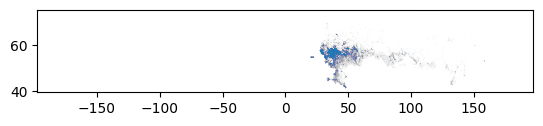

In [124]:
geo_gdf.plot()

# Нарисовать объединение точки с полигоном

In [47]:
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [58]:
# Пример создания GeoDataFrame с полигоном (замените этот код вашим GeoDataFrame)
polygon = geo_gdf[geo_gdf.name == "Ставрополь"]

<Axes: >

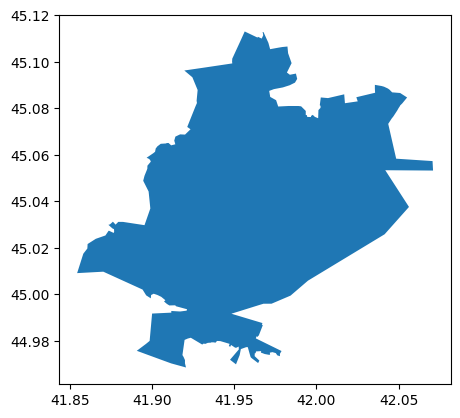

In [62]:
polygon.plot()

In [105]:
# Создаем точку (пример: точка внутри полигона)
points = [
    Point(41.954969, 45.038849),
    Point(41.978939, 45.035405),
    Point(41.957829, 45.016347),
    Point(41.917783, 45.005327),
    Point(41.941120, 45.074587),
    Point(42.038719, 45.032804),
    Point(42.05, 44.98),
]

In [106]:
# Преобразуем точку в GeoDataFrame
gdf_point = gpd.GeoDataFrame(geometry=points)

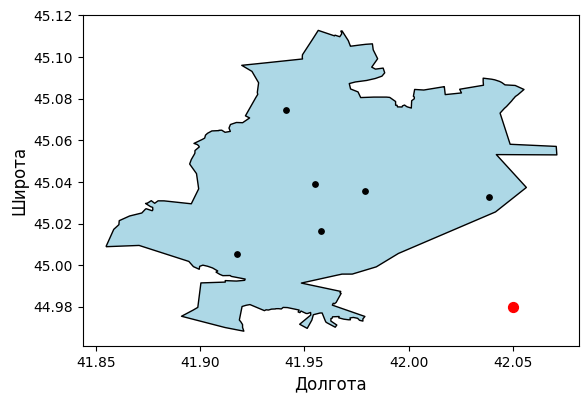

In [121]:
# Рисуем полигон Ставрополя
ax = polygon.plot(color="lightblue", edgecolor="black")

# Рисуем все точки кроме последней
gdf_point.iloc[:-1].plot(ax=ax, color="black", marker="o", markersize=15)

# Рисуем последнюю точку отдельно, выделяя ее черным цветом и большим размером
gdf_point.iloc[-1:].plot(ax=ax, color="red", marker="o", markersize=50)

# Добавляем заголовок и подписи осей
# plt.title("Пример: Объединение точек с полигоном г. Ставрополь", fontsize=12)
plt.xlabel("Долгота", fontsize=12)
plt.ylabel("Широта", fontsize=12)


# Показать график
plt.show()
# plt.savefig("foo.png")

In [ ]:
print(len(geo_gdf))

In [ ]:
logging.getLogger().setLevel(logging.CRITICAL)


def save_geo_chunks(gdf, output_dir="geo_chunks", min_file_size_mb=18, max_file_size_mb=18.2):
    """
    Разбивает GeoDataFrame на части и сохраняет каждую часть в отдельный файл,
    когда размер файла находится в пределах от min_file_size_mb до max_file_size_mb.
    
    :param gdf: GeoDataFrame, который нужно разбить
    :param output_dir: Директория для сохранения файлов
    :param min_file_size_mb: Минимальный размер файла в мегабайтах
    :param max_file_size_mb: Максимальный размер файла в мегабайтах
    """
    
    # Создаем директорию для сохранения, если её нет
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Максимальный и минимальный размер файла в байтах
    min_file_size_bytes = min_file_size_mb * 1024 * 1024
    max_file_size_bytes = max_file_size_mb * 1024 * 1024

    chunk = []
    file_count = 1
    rows_in_chunk = 0

    for index, row in gdf.iterrows():
        # Добавляем строку в текущий chunk
        chunk.append(row)
        rows_in_chunk += 1

        # Проверяем, добавилось ли 100 строк
        if rows_in_chunk >= 200:
            # Создаем временный GeoDataFrame для расчета размера
            temp_gdf = gpd.GeoDataFrame(chunk, columns=gdf.columns, crs=gdf.crs)

            # Сохраняем временный файл для проверки размера
            temp_file = os.path.join(output_dir, "temp.geojson")
            temp_gdf.to_file(temp_file, driver="GeoJSON")
            current_size = os.path.getsize(temp_file)

            # Проверяем, находится ли размер файла в пределах от 18 до 18.2 мегабайт
            if min_file_size_bytes <= current_size <= max_file_size_bytes:
                # Сохраняем текущий chunk в файл
                output_file = os.path.join(output_dir, f"chunk_{file_count}.geojson")
                temp_gdf.to_file(output_file, driver="GeoJSON")
                print(f"Сохранен {output_file}, размером {os.path.getsize(output_file) / (1024 * 1024):.2f} MB")

                # Очищаем текущий chunk и начинаем новый
                chunk = []
                rows_in_chunk = 0
                file_count += 1

    # Сохраняем оставшийся chunk, если он существует
    if chunk:
        output_file = os.path.join(output_dir, f"chunk_{file_count}.geojson")
        final_gdf = gpd.GeoDataFrame(chunk, columns=gdf.columns, crs=gdf.crs)
        final_gdf.to_file(output_file, driver="GeoJSON")
        print(f"Сохранен {output_file}, размером {os.path.getsize(output_file) / (1024 * 1024):.2f} MB")

    # Удаляем временный файл
    if os.path.exists(temp_file):
        os.remove(temp_file)

# Пример использования:
gdf = geo_gdf
save_geo_chunks(gdf)